In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import scipy.optimize as sc
import matplotlib.pyplot as plt

from main import get_portfolio

In [2]:
RFR = 0.00

In [3]:
def get_owned():
    port = get_portfolio()
    owned = list(port[0].index)
    faulty = ['KCS','CHSB','LTO','LYXe','REN','FORTH','RFUEL','REVV','USDT', 'USD', 'NMR','STMX']
    rename = {'ATOM': 'ATOM1', 'DOT': 'DOT1', 'GRT': 'GRT2', 'ONE': 'ONE2', 'SOL': 'SOL1'}
    owned = [ticker for ticker in owned if ticker not in faulty]
    owned = sorted([ticker+'-USD' if ticker not in rename.keys() else rename[ticker]+'-USD' for ticker in owned])
    return owned

def get_data(assets, start, end, log):
    asset_data = yf.download(assets, start=start, end=end)
    asset_data = asset_data['Adj Close']
    delta_days = len(asset_data)
    if log:
        returns = np.log(asset_data / asset_data.shift(1))    
    else:
        returns = asset_data.pct_change()                    
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return mean_returns, cov_matrix, delta_days

def port_performance(weights, mean_returns, cov_matrix, delta_days):
    expected_returns = np.sum(mean_returns * weights) * delta_days
    expected_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(delta_days)
    return expected_returns, expected_volatility

def port_returns(weights, mean_returns, cov_matrix, delta_days, negative):
    if negative:
        return -1 * port_performance(weights, mean_returns, cov_matrix, delta_days)[0]
    else:
        return port_performance(weights, mean_returns, cov_matrix, delta_days)[0]

def port_volatility(weights, mean_returns, cov_matrix, delta_days):
    return port_performance(weights, mean_returns, cov_matrix, delta_days)[1]

def negative_sharpe(weights, mean_returns, cov_matrix, delta_days, rfr=RFR):
    expected_returns, expected_volatility = port_performance(weights, mean_returns, cov_matrix, delta_days)
    sharpe_ratio = (expected_returns - rfr) / expected_volatility
    neg_sharpe = -1 * sharpe_ratio
    return neg_sharpe

def maximize_returns(mean_returns, cov_matrix, delta_days, bound=(0,1)):
    num_assets = len(mean_returns)
    initial_weights = num_assets * [1.0 / num_assets]
    arguments = (mean_returns, cov_matrix, delta_days)
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    result = sc.minimize(port_returns(negative=True), initial_weights, method='SLSQP', args=arguments, bounds=bounds, constraints=constraints)
    return result

def minimize_volatility(mean_returns, cov_matrix, delta_days, bound=(0,1)):
    num_assets = len(mean_returns)
    initial_weights = num_assets * [1.0 / num_assets]
    arguments = (mean_returns, cov_matrix, delta_days)
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    result = sc.minimize(port_volatility, initial_weights, method='SLSQP', args=arguments, bounds=bounds, constraints=constraints)
    return result

def maximize_sharpe(mean_returns, cov_matrix, delta_days, bound=(0,1)):
    num_assets = len(mean_returns)
    initial_weights = num_assets * [1.0 / num_assets]
    arguments = (mean_returns, cov_matrix, delta_days)
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    result = sc.minimize(negative_sharpe, initial_weights, method='SLSQP', args=arguments, bounds=bounds, constraints=constraints)
    return result

def simulate_portfolios(mean_returns, cov_matrix, delta_days):
    num_ports = 10000
    sharpe_ratios = np.zeros(num_ports)
    exp_returns = np.zeros(num_ports)
    exp_vols = np.zeros(num_ports)
    for k in range(num_ports):
        weights = np.array(np.random.random(len(mean_returns)))
        weights = weights / np.sum(weights)
        exp_returns[k], exp_vols[k] = port_performance(weights, mean_returns, cov_matrix, delta_days)
        sharpe_ratios[k] = exp_returns[k] / exp_vols[k]
    return exp_returns, exp_vols, sharpe_ratios

def efficient_frontier(mean_returns, cov_matrix, delta_days, return_target, bound=(0,1)):
    num_assets = len(mean_returns)
    initial_w = num_assets * [1.0 / num_assets]
    arguments = (mean_returns, cov_matrix, delta_days)
    bounds = tuple(bound for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: port_returns(w, mean_returns, cov_matrix, delta_days, negative=False) - return_target})
    opt = sc.minimize(port_volatility, initial_w, method='SLSQP', args=arguments, bounds=bounds, constraints=constraints)
    return opt['fun']

def get_results(mean_returns, cov_matrix, delta_days):
    max_rets_port = maximize_returns(mean_returns, cov_matrix, delta_days)['x']
    max_rets_returns, max_rets_vol = port_performance(max_rets_port, mean_returns, cov_matrix, delta_days)

    min_vol_port = minimize_volatility(mean_returns, cov_matrix, delta_days)['x']
    min_vol_returns, min_vol_vol = port_performance(min_vol_port, mean_returns, cov_matrix, delta_days)

    max_sharpe_port = maximize_sharpe(mean_returns, cov_matrix, delta_days)['x']
    max_sharpe_returns, max_sharpe_vol = port_performance(max_sharpe_port, mean_returns, cov_matrix, delta_days)

    frontier_list = []
    target_returns = np.linspace(min_vol_returns, max_rets_returns, 50)
    for return_target in target_returns:
        frontier_list.append(efficient_frontier(mean_returns, cov_matrix, delta_days, return_target))

    max_rets_perf = (round(max_rets_returns * 100, 3), round(max_rets_vol * 100, 3), [round(i * 100, 3) for i in max_rets_port])
    min_vol_perf = (round(min_vol_returns * 100, 3), round(min_vol_vol * 100, 3), [round(i * 100, 3) for i in min_vol_port])
    max_sharpe_perf = (round(max_sharpe_returns * 100, 3), round(max_sharpe_vol * 100, 3), [round(i * 100, 3) for i in max_sharpe_port])

    return max_rets_perf, min_vol_perf, max_sharpe_perf, frontier_list, target_returns




In [4]:
# assets = get_owned()

In [23]:
# assets = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'SOL1-USD']

assets = ['CEVA', 'GOOGL', 'TSLA', 'ZOM']

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=30)

# start_date = dt.date(2021, 1, 1)
# end_date = dt.date(2021, 1, 23)

mean_returns, cov_matrix, delta_days = get_data(assets, start_date, end_date, log=False)

[*********************100%***********************]  4 of 4 completed


In [25]:
maxIndex = sharpe_ratio.argmax()
weight[maxIndex, :]

array([0.02542431, 0.0026812 , 0.97031546, 0.00157903])

In [26]:
returns = np.linspace(exp_returns.min(), exp_returns.max(), 50)
vol_opt = []
bounds = tuple((0,1) for asset in range(len(mean_returns)))
def min_vol(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    return V
def get_return(w):
    w = np.array(w)
    R = np.sum(mean_returns*w)
    return R
for R in returns:
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                    {'type': 'eq', 'fun': lambda w: get_return(w) - R})
    opt = sc.minimize(min_vol, initial_w, method='SLSQP', bounds=bounds, constraints=constraints)
    vol_opt.append(opt['fun'])

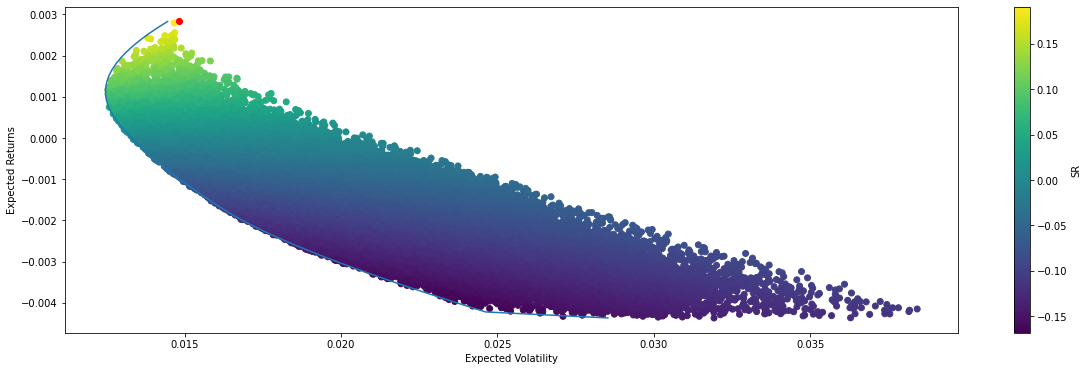

In [27]:
plt.figure(figsize=(20, 6))
plt.scatter(exp_vol, exp_returns, c=sharpe_ratio)
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Returns")
plt.colorbar(label="SR")
plt.scatter(exp_vol[maxIndex], exp_returns[maxIndex], c="red")
plt.plot(vol_opt, returns)
plt.show()

In [28]:
result = maximize_sharpe(mean_returns, cov_matrix, delta_days)
vector = result['x']
optimal_weights = [{ticker.split('-')[0]:round(x, 3)} for ticker,x in zip(assets,vector)]
list(optimal_weights[0].values())[0] > 0
final = [d for d in optimal_weights if list(d.values())[0] > 0] 
print(final)

[{'TSLA': 1.0}]
